# 基于PaddlePaddle2.2的影像复原及修复实现
---


# 1.项目背景及概述

老照片和历史影像作为一段时期的特定影像记录，承载着宝贵的记忆，它有着不可替代的意义。然而老照片由于年代久远、当时技术的不成熟或者保存不当等因素，或多或少出现发黄、折痕、磨损，甚至表层还会出现不规则剥落及破洞现象，因此需要对这些老照片进行图像修复。

![](https://ai-studio-static-online.cdn.bcebos.com/b06f1f10c9f44068b8cd5f4b514011ba0d49f6c35b00409ba7e08619d5b73661)

同时，上个年代的黑白历史影像，由于当时的拍摄硬件受限，成像色彩和分辨率都受到硬件本身影响，这些历史影像大多是低分辨率且色彩黑白的，在复原工作时，需要对其进行超分辨率重建和色彩补充等图像处理。

![](https://ai-studio-static-online.cdn.bcebos.com/9355f1c77bb64945849673a95e62ee0a91e23dfa4aa54ccebfd7d719dce56278)


图像修复是指在一张图片中存在局部区域破损或缺失，需要利用已有的边缘信息来将这些破损区域进行修复或补全的技术。该技术被广泛用于修复受损的图片、文物以及去除不需要的遮挡物等方面。

传统的图像修复算法主要包括偏微分算法和纹理合成算法，由于仅利用原图中存留的周边信息，局限性明显。当待修复区域包含复杂、非重复结构时，修复效果不尽人意。

近年来，深度学习在计算机视觉和图像处理领域的研究不断取得进步，使用海量图片对网络进行训练，使得训练好的模型可以具备大量的先验知识，为图像修复提供了另外一种思路。尤其是生成对抗网络的提出，在图像修复领域取得了很好的效果。

---

# 2.技术难点分析

2006年 ,Deepak Pathak等人使用简单的编码解码器作为图像修复的主网络，通过编码部分得出低维特征图，解码部分使用提取到的特征来修复缺损区域并还原整个图像，并使用判别器监督使得修复区域尽可能地和原始图像接近，但是由于通道全连通层的信息瓶颈，使得输出图像的修复区域往往含有视觉伪影，表现出模糊的特征，修补痕迹明显。

目前可将老照片修复遇到的问题归纳为以下三点：
- 目前还没有能够真实呈现老照片伪影退化的真实模型；
- 照片的复含退化修 复往往需要不同的策略， 如非结构化缺陷往往是均匀的，类缺陷最常见的是褪色缺陷一般需要利用临近像素点的信息来修复，而结构性缺陷，例如划痕斑点，往往需要利用全局图像信息来修复。
- 在人物照片修复中， 观看者往往更关注人脸信息，考虑到肖像占老照片很大比例，我们还需要设计特定对人脸进行修复的网络。

此外，可将历史影像复原存在的问题归纳为以下：
- 由于历史影像的拍摄设备以及成像技术的落后，相较于目前的高分辨率高饱和度显示，历史影像的分辨率需要进行图像高清化，色彩需要进行接近原始影像本身的补充。
- 同时受散光、失焦等其他各种因素影响，历史影像不可避免地引入不同程度的模糊和噪声，从而引起影像质量下降或退化。影像的退化，其中噪声和模糊是最主要的退化因素。

---

# 3.解决方案

## 3.1 总体方案
![](https://ai-studio-static-online.cdn.bcebos.com/275b4970d2be419489e2784cf8a3ef1c1d419160384a4b89adffd0bcab929b02)

## 3.2 照片修复方案

对于老照片修复等问题，采用基于Self-Attention自注意力机制的对抗式生成网络[《Self-Attention GAN》](https://arxiv.org/pdf/1805.08318.pdf)来作为主要方案，另外增加其他的传统图像处理方法来进行类似于孔洞、缺陷的小面积修补。

![](https://ai-studio-static-online.cdn.bcebos.com/fa747daa4ad04dd38741d4cebd840623360fd82b2b8a4768afe4097c70ae4dc9)

## 3.3 历史影像复原方案
对于历史影像复原等问题，以论文[《Colorful Image Colorization》](https://arxiv.org/abs/1603.08511)和,[《Learning Representations for Automatic Colorization》](https://arxiv.org/pdf/1603.08511.pdf)作为主要参考方案。

在着色过程中利用了低层和语义表示。由于目前许多场景元素是根据多峰颜色分布自然产生的，因此训练我们的模型来预测像素颜色直方图。这个中间输出可用于自动生成彩色图像，或在图像形成之前进行进一步操作。

![](https://ai-studio-static-online.cdn.bcebos.com/348146f602d4469d9bf080e5ec0f8a539349bfcfed8f45ada465cd430885f66f)

![](https://ai-studio-static-online.cdn.bcebos.com/900bc3e4c9d34659b55b8f409c090e485452a7f1460546cd85a2081e913a9948)

---

# 4.模型设计

## 4.1 输入输出层和数据设计

### 4.1.1 Lab格式数据

Lab模式由三个通道组成，但不是R、G、B[通道](https://baike.baidu.com/item/通道)。它的一个通道是明度，即L。另外两个是色彩通道，用A和B来表示。A通道包括的颜色是从深绿色（低亮度值）到灰色（中亮度值）再到亮粉红色（高亮度值）；B通道则是从深蓝色（低亮度值）到灰色（中亮度值）再到黄色（高亮度值）。因此，这种色彩混合后将产生明亮的色彩。


![](https://ai-studio-static-online.cdn.bcebos.com/192d2e420fc14e63847fb96027aac68c2e5da924939c4f53b862b9a73c127ffe)

### 4.1.2 输入层

这里由于输入的历史影像数据基本是黑白色彩的，因此索引在输入时将其转换为灰度图片，那么输入的图片通道就从三通道变为单通道了，可用张量[C,H,W]表示为[1,H,W]，其中第一位C为输入图片的维度，也就是转换后灰度图片的通道数，H为输入图片的高度，W为输入图片的高度。

为了将输入层传入的RGB图片中灰度信息和颜色信息分离开，我们可以尝试将RGB颜色转换为LAB颜色模式，在LAB颜色方案中，L为图片的纹理与轮廓信息，AB则为两个负责颜色的通道。我们可以在输入彩色数据时对其进行处理，输入L通道，让模型预测AB两通道，最后输出的AB通道的像素值就能够实现颜色信息的推理预测。

代码实现如下：

```python
import paddle
import paddle.nn as nn


class BaseColor(nn.Layer):
    def __init__(self):
        super(BaseColor, self).__init__()

        self.l_cent = 50.0
        self.l_norm = 100.0
        self.ab_norm = 110.0

    def normalize_l(self, in_l):
        return (in_l - self.l_cent) / self.l_norm

    def unnormalize_l(self, in_l):
        return in_l * self.l_norm + self.l_cent

    def normalize_ab(self, in_ab):
        return in_ab / self.ab_norm

    def unnormalize_ab(self, in_ab):
        return in_ab * self.ab_norm
```

### 4.1.3 输出层

此外，论文作者为了避免最终生成的颜色数量较少，因此分别对原本取值为0~255的A和B两个颜色信息通道进行相应的压缩，于是输入的256*256个像素就组合编程313组的高频颜色分类，同时也将[B,H,W,C]的格式降低为[H,W,313]。其中313代表313个颜色组合所分别对应的“概率”。

代码实现如下：

```python
import numpy as np
import paddle
import paddle.nn as nn

from .base_color import *


class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2D):
        super(ECCVGenerator, self).__init__()

        model1 = [ nn.Conv2D(1, 64, kernel_size=3, stride=1, padding=1),]
        model1 += [ nn.ReLU(True),]
        model1 += [ nn.Conv2D(64, 64, kernel_size=3, stride=2, padding=1),]
        model1 += [ nn.ReLU(True),]
        model1 += [norm_layer(64),]
        
        model2 = [nn.Conv2D(64, 128, kernel_size=3, stride=1, padding=1),]
        model2 += [ nn.ReLU(True),]
        model2 += [nn.Conv2D(128, 128, kernel_size=3, stride=2, padding=1),]
        model2 += [nn.ReLU(True),]
        model2 += [norm_layer(128),]
        
        model3 = [nn.Conv2D(128, 256, kernel_size=3, stride=1, padding=1),]
        model3 += [ nn.ReLU(True),]
        model3 += [ nn.Conv2D(256, 256, kernel_size=3, stride=1, padding=1),]
        model3 += [nn.ReLU(True),]
        model3 += [ nn.Conv2D(256, 256, kernel_size=3, stride=2, padding=1),]
        model3 += [nn.ReLU(True),]
        model3 += [norm_layer(256),]
        
        model4 = [nn.Conv2D(256, 512, kernel_size=3, stride=1, padding=1),]
        model4 += [nn.ReLU(True),]
        model4 += [nn.Conv2D(512, 512, kernel_size=3, stride=1, padding=1),]
        model4 += [nn.ReLU(True),]
        model4 += [nn.Conv2D(512, 512, kernel_size=3, stride=1, padding=1),]
        model4 += [nn.ReLU(True),]
        model4 += [norm_layer(512),]
        
        model5 = [
            nn.Conv2D(512, 512, kernel_size=3, dilation=2, stride=1, padding=2),
        ]
        model5 += [nn.ReLU(True),]
        model5 += [
            nn.Conv2D(512, 512, kernel_size=3, dilation=2, stride=1, padding=2),
        ]
        model5 += [ nn.ReLU(True),]
        model5 += [
            nn.Conv2D(512, 512, kernel_size=3, dilation=2, stride=1, padding=2),
        ]
        model5 += [ nn.ReLU(True),]
        model5 += [ norm_layer(512),]
        
        model6 = [
            nn.Conv2D(512, 512, kernel_size=3, dilation=2, stride=1, padding=2),
        ]
        model6 += [nn.ReLU(True),]
        model6 += [
            nn.Conv2D(512, 512, kernel_size=3, dilation=2, stride=1, padding=2),
        ]
        model6 += [nn.ReLU(True),]
        model6 += [
            nn.Conv2D(512, 512, kernel_size=3, dilation=2, stride=1, padding=2),
        ]
        model6 += [ nn.ReLU(True),]
        model6 += [ norm_layer(512),]

        model7 = [ nn.Conv2D(512, 512, kernel_size=3, stride=1, padding=1),]
        model7 += [ nn.ReLU(True),]
        model7 += [
            nn.Conv2D(512, 512, kernel_size=3, stride=1, padding=1),
        ]
        model7 += [nn.ReLU(True),]
        model7 += [
            nn.Conv2D(512, 512, kernel_size=3, stride=1, padding=1),
        ]
        model7 += [ nn.ReLU(True),]
        model7 += [norm_layer(512),]

        model8 = [nn.Conv2DTranspose(512, 256, kernel_size=4, stride=2, padding=1)]
        model8 += [ nn.ReLU(True),]
        model8 += [
            nn.Conv2D(256, 256, kernel_size=3, stride=1, padding=1),
        ]
        model8 += [ nn.ReLU(True),]
        model8 += [
            nn.Conv2D(256, 256, kernel_size=3, stride=1, padding=1),
        ]
        model8 += [ nn.ReLU(True),]

        model8 += [
            nn.Conv2D(256, 313, kernel_size=1, stride=1, padding=0),
        ]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(axis=1)
        self.model_out = nn.Conv2D(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias_attr=False
        )
        self.upsample4 = nn.Upsample(scale_factor=4, mode="bilinear")

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))

        return self.unnormalize_ab(self.upsample4(out_reg))
```

## 4.2 损失计算

计算AB两个颜色通道的损失

```python
# 计算交叉熵损失
criterion = nn.CrossEntropyLoss(soft_label=True)

out, target = model(batch[0][0],batch[0][1])   
            loss = criterion(out, target)
            loss.backward()  
            adam.step()
            scheduler.step()
            adam.clear_grad()
            train_loss.append(loss.numpy())
# 求均值   
loss = np.mean(train_loss)
```

## 4.3 Backbone骨干网络设计

这里使用VGG作为分类网络骨干，将VGG16分类器来评估着色结果的语义可解释性。


![](https://ai-studio-static-online.cdn.bcebos.com/e5ed2e370eda4a5bab573bf6153439b65c825f656e5e4f49a2d0556d3a702855)



```python
classifier = vgg16(pretrained=True)
    model.eval()
    classifier.eval()
    valImageLoader = val_loader("model/pretrain/val.txt")
    test_origin_dataset = ImageFolder(os.path.join(opt.data_dir, "val"), loader=valImageLoader.load)
    test_vgg_dataset = paddle.io.Subset(dataset=test_origin_dataset, indices=range(5000,5500))
    test_vgg_loader = DataLoader(test_vgg_dataset,
                        #places = place,
                        batch_size=1,
                        #shuffle=True,
                        drop_last=True,
                        num_workers=8)

    m = paddle.metric.Accuracy()
    m_origin = paddle.metric.Accuracy()
    res = m.accumulate()
    img_mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    img_std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
```

## 4.4 优化器设计

这里使用adam进行模型参数优化，并设置学习率以默认参数阶梯式衰减下降。

```python
scheduler = paddle.optimizer.lr.PiecewiseDecay(boundaries=[2e5, 375e3], 
                                                values=[3e-5, 1e-5, 3e-6], 
                                                )
adam = paddle.optimizer.Adam(learning_rate=scheduler,
                                beta1=0.9, 
                                beta2=0.99,
                                weight_decay=1e-3,
                                parameters=model.parameters())
```

---

# 5.数据准备

## 5.1 ImageNet数据集介绍

ImageNet数据集是一个计算机视觉数据集，是由斯坦福大学的李飞飞教授带领创建。该数据集包合 14,197,122张图片和21,841个Synset索引。 Synset是WordNet层次结构中的一个节点，它又是一组同义词集合。

ImageNet数据集一直是评估图像分类算法性能的基准。
ImageNet 数据集是为了促进计算机图像识别技术的发展而设立的一个大型图像数据集。2016 年ImageNet 数据集中已经超过干万张图片，每一张图片都被手工标定好类别。ImageNet 数据集中的图片涵盖了大部分生活中会看到的图片类别。ImageNet最初是拥有超过100万张图像的数据集。如图下图所示，它包含了各种各样的图像，并且每张图像都被关联了标签（类别名）。每年都会举办使用这个巨大数据集的ILSVRC图像识别大赛。

ImageNet数据集是为了促进计算机图像识别技术的发展而设立的一个大型图像数据集。2016 年ImageNet数据集中已经超过干万张图片，每一张图片都被手工标定好类别。ImageNet 数据集中的图片涵盖了大部分生活中会看到的图片类别。ImageNet最初是拥有超过100万张图像的数据集。如图下图所示，它包含了各种各样的图像，并且每张图像都被关联了标签（类别名）。每年都会举办使用这个巨大数据集的ILSVRC图像识别大赛。

![](https://ai-studio-static-online.cdn.bcebos.com/72a44a20c269417f8ed4037791757b4a71dbf44f9b2f4073a91a77659fe34f02)


## 5.2 数据集的下载与使用

由于ImageNet数据集图片数量非常多，总的容量达到160+G的规模，因此这里仅为验证与测试，选用了容量更小更为精简的ImageNet-mini数据集，麻雀虽小五脏俱全，它同样包含了1000类的图像类别数据。


In [ ]:
# 解压数据集进行模型验证
!tar xvf  /home/aistudio/data/data68594/ILSVRC2012_img_val.tar -C data/val/

# 6.模型训练

由于数据集规模较大，同时需要的算力资源也很多，因此这里的训练过程单独另起了一个脚本任务进行模型的训练。

## 6.1 训练项目同步
![](https://ai-studio-static-online.cdn.bcebos.com/e6a1c038c55f4a78b8178b393914b7e7938e7e6649de4f88b223033535de8bdd)

![](https://ai-studio-static-online.cdn.bcebos.com/9d7185eaf39f49b0b134d5e6029d483017a904fa94644c318b3be4d4dbe29ab3)

![](https://ai-studio-static-online.cdn.bcebos.com/bb5e314471b34508ad71b8530c51f93864699ff005ad42c7b32aeaf16e0ae4e8)

## 6.2 查看训练日志

![](https://ai-studio-static-online.cdn.bcebos.com/dd998df3f5ef4637be0280c5b067c9a26dd3230c3eee48e0b55aed140e3f6efc)



## 6.3 任务公开链接

训练脚本任务：[链接](https://aistudio.baidu.com/aistudio/clusterprojectdetail/3501298)

# 7.模型评估

In [39]:
# 模型评估 执行脚本
!python train.py --use_gpu -e 0 --pretrain --data_dir 'data/'

W0220 00:12:04.270402  6616 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0220 00:12:04.274488  6616 device_context.cc:465] device: 0, cuDNN Version: 7.6.
finished 0! Acc = 0.0, origin Acc = 0.0
finished 100! Acc = 0.504950495049505, origin Acc = 0.5148514851485149
finished 200! Acc = 0.5024875621890548, origin Acc = 0.5074626865671642
finished 300! Acc = 0.5016611295681063, origin Acc = 0.4983388704318937
finished 400! Acc = 0.5236907730673317, origin Acc = 0.5187032418952618
0.522 0.52


# 8.模型推理
## 8.1 安装相关依赖库

In [ ]:
pip install scikit-Image

In [ ]:
pip install amp

In [ ]:
pip install argparse

## 8.2 执行预测

In [7]:
# 执行推理预测脚本 imgs/10.jpg为预测图片路径
!python demo_release.py -i imgs/10.jpg

W0219 23:21:15.982959  1528 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0219 23:21:15.987287  1528 device_context.cc:465] device: 0, cuDNN Version: 7.6.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


## 8.3 结果可视化

下面进行可视化预测结果，分别对于输入的原图以及ECCV16和SIGGRAPH17的结果。

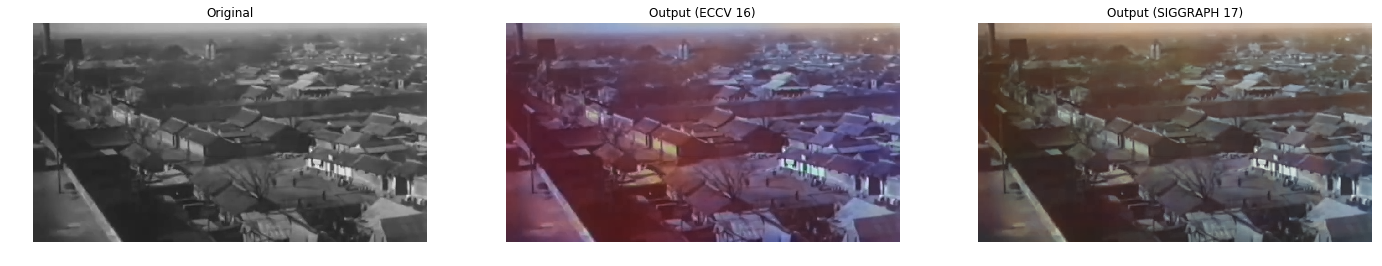

In [8]:
import imageio
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

plt.figure(figsize=(24, 24))
plt.subplot(1, 3, 1)

img_path = 'imgs/10.jpg'
plt.imshow(cv2.imread(img_path))
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
#plt.imshow(out_img_eccv16)
plt.imshow(cv2.imread("saved" + "_eccv16.png"))
plt.title("Output (ECCV 16)")
plt.axis("off")

plt.subplot(1, 3, 3)
#plt.imshow(out_img_siggraph17)
plt.imshow(cv2.imread("saved" + "_siggraph17.png"))
plt.title("Output (SIGGRAPH 17)")
plt.axis("off")
plt.show()

# 9.模型优化


待续

# 10.模型可视化

![](https://ai-studio-static-online.cdn.bcebos.com/437798a53e374fa8a8e46f9885733416bd02d24247004565a67c35bcbc499bc1)


# 11.视频预测结果
制作中

## 参考材料

1. https://arxiv.org/pdf/1603.08511.pdf
2. https://arxiv.org/pdf/1805.08318.pdf
3. http://people.cs.uchicago.edu/~larsson/colorization/
4. https://github.com/gustavla/autocolorize
5. https://github.com/Phimos/Paddle-Colorization
6. https://github.com/ZMpursue/PaddleColorization
7. https://github.com/Callifrey/Paddle-CIC
8. https://github.com/nku-shengzheliu/PaddlePaddle-Colorful-Image-Colorization